# Wellbeing Police

From various subreddit, we have scraped close to 4000 posts. The subreddits include "r/SuicideWatch", "r/BipolarReddit", "r/Anxiety", "r/AnxietyDepression", "r/Depression", and "r/Happy". Each of the subreddit posts currently sitting within its own csv file. We will see what are the fields that are consistent across the CSV files and choose those applicable. Clean up the data, removed the columns not needed. 

As all the scrapes was created from the same script, the columns of the resulting csv are same across the files. 
We will proceed to label them according to the subreddit they came from and combine them into a single dataframe.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import glob
import os
import spacy
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from torchtext.data.utils import get_tokenizer
from sklearn.metrics import classification_report

from src.utils import color_func, get_mask, search,text_normalization

### Data Combination and Labeling

We retrieved posts in “Hot” section from various subreddits:
`r/ptsd`,`r/Anxiety`,`r/SuicideWatch`,`r/depression`,`r/BipolarReddit`,`r/schizophrenia`,`r/EDAnonymous`,`r/EatingDisorders`

In [3]:
path = "./reddit/csvs/"
all_csvs = glob.glob(os.path.join(path, "*.csv"))

all_dfs = []
for filename in all_csvs:
    df = pd.read_csv(filename, index_col=None, header=0)
    df = df[["title", "subreddit", "body"]]
    df = df[2:]
    
    # ## manually remove irrelevant pinned posts
    # if df.iloc[0].subreddit in ["ptsd",'Anxiety',"SuicideWatch",'EDAnonymous']: 
    #     df=df[2:]
    # if df.iloc[0].subreddit in ['BipolarReddit','schizophrenia','EatingDisorders']:
    #     df=df[1:]
        
    all_dfs.append(df)

# main_df = pd.concat(all_dfs)
# print(main_df.shape)
# main_df = main_df.drop_duplicates()
# print(main_df.shape)
# main_df = main_df.dropna()
# print(main_df.shape)
# main_df.head()


# main_df["body"] = main_df["title"] + " " + main_df["body"]
# main_df = main_df.drop_duplicates()
# print(main_df.shape)
# main_df = main_df.dropna()
# print(main_df.shape)
# main_df.head()

main_df = pd.concat(all_dfs)
print(main_df.shape)
main_df = main_df.fillna('')
main_df["body"] = main_df["title"] + " " + main_df["body"]
main_df = main_df.drop_duplicates()
print(main_df.shape)
main_df = main_df.dropna()
print(main_df.shape)
main_df.head()


main_df = main_df.drop_duplicates()
print(main_df.shape)
main_df = main_df.dropna()
print(main_df.shape)
main_df.head()


(34785, 3)
(24291, 3)
(24291, 3)
(24291, 3)
(24291, 3)


,title,subreddit,body
2,Just swallowed half a bottle of Tylenol waitin...,SuicideWatch,Just swallowed half a bottle of Tylenol waitin...
3,I just want to be normal,SuicideWatch,I just want to be normal I’ve been depressed/s...
4,I am really struggling. I need help. Anything ...,SuicideWatch,I am really struggling. I need help. Anything ...
5,i discontinued my own suicide attempt,SuicideWatch,i discontinued my own suicide attempt i don‘t ...
6,"I always look outside of the window, dreaming ...",SuicideWatch,"I always look outside of the window, dreaming ..."


A few of the subreddit is indicating the same underlying mental problems, we proceed to add an attribute such that these minor differentiation will be grouped for better and easier identification.

<Axes: title={'center': 'Class Counts'}>

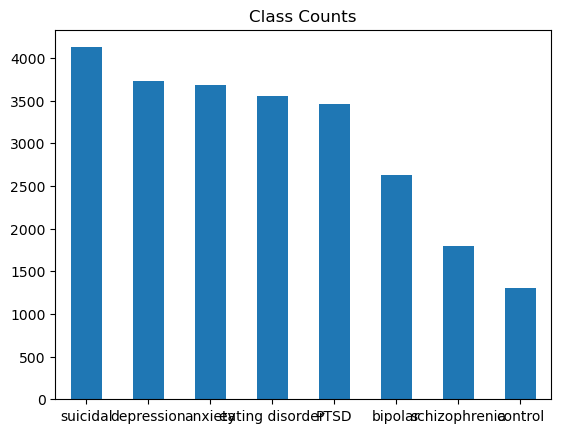

In [4]:
sub_problem_mapping = {
    "ptsd": "PTSD",
    "CPTSD": "PTSD",
    "Anxiety": "anxiety",
    "Anxietyhelp": "anxiety",
    "SuicideWatch": "suicidal",
    "selfharm": "suicidal",
    "depression": "depression",
    "depression_help": "depression", 
    "BipolarReddit": "bipolar", 
    "bipolar": "bipolar",
    "schizophrenia": "schizophrenia",
    "EDAnonymous": "eating disorder",
    "EatingDisorders": "eating disorder",
    "happy": "control",
    "MadeMeSmile": "control"
}

main_df["problem"] = [sub_problem_mapping[s] for s in main_df["subreddit"]]
main_df.head()
main_df["problem"].value_counts().plot.bar(rot=0, title="Class Counts")

#NEED TO DECIDE whether need to drop control.

In [5]:
df_PTSD = main_df[main_df['problem'] == 'PTSD']
df_anxiety = main_df[main_df['problem'] == 'anxiety']
df_suicidal = main_df[main_df['problem'] == 'suicidal']
df_depression = main_df[main_df['problem'] == 'depression']
df_bipolar = main_df[main_df['problem'] == 'bipolar']
df_schizophrenia = main_df[main_df['problem'] == 'schizophrenia']
df_eating_disorder = main_df[main_df['problem'] == 'eating disorder']
df_control = main_df[main_df['problem'] == 'control']

df_PTSD = df_PTSD[:1500]
df_anxiety = df_anxiety[:1500]
df_suicidal = df_suicidal[:1500]
df_depression = df_depression[:1500]
df_bipolar = df_bipolar[:1500]
df_schizophrenia = df_schizophrenia[:1500]
df_eating_disorder = df_eating_disorder[:1500]
# df_control = df_control[:1500]
all_dfs = []
all_dfs.append(df_PTSD)
all_dfs.append(df_anxiety)
all_dfs.append(df_suicidal)
all_dfs.append(df_depression)
all_dfs.append(df_bipolar)
all_dfs.append(df_schizophrenia)
all_dfs.append(df_eating_disorder)
all_dfs.append(df_control)
main_df = pd.concat(all_dfs)

<Axes: title={'center': 'Class Counts'}>

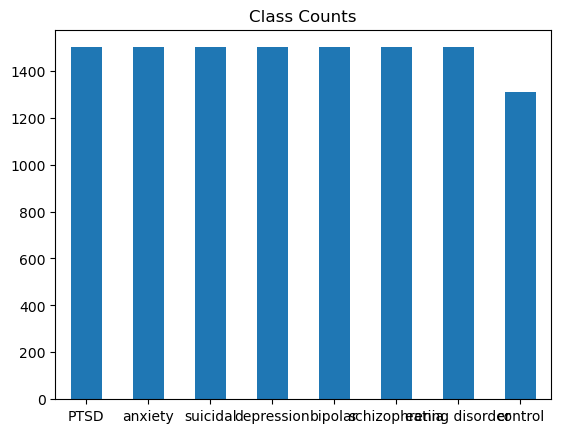

In [6]:
main_df["problem"].value_counts().plot.bar(rot=0, title="Class Counts")

In [7]:

# Normalization codes from the notebook
# Note that we did not include removal of words in brackets as well as odd characters as
# these may denote some emotion (anger for instance may lead to multiple !!!). 
def normalizer(s):
    s = s.lower()                                                   # Lowercase whole sentence
    s = re.sub(r'\s+', ' ', s)                                      # Remove duplicate whitespaces
    s = re.sub(r'([.]){2,}', ' ', s)                                # Remove ellipses ...
    s = re.sub(r'([\w.-]+)([,;])([\w.-]+)', '\g<1>\g<2> \g<3>', s)  # Add missing whitespace after , and ;
    s = re.sub(r'(.+)\1{2,}', '\g<1>\g<1>', s)                      # Reduce repeated sequences to 2
    #s = re.sub(r'[\(\[].*?[\)\]]', ' ', s)                          # Remove all words in brackets
    s = re.sub(r'(n\'t)', ' not', s)                                # Resolve contraction "-n't"
    # s = re.sub(r'[^a-zA-Z0-9_-]+', ' ', s)                         # Remove all "odd" characters
    s = re.sub(r'\s+', ' ', s)                                      # Remove duplicate whitespaces (again)
    s = s.strip()                                                   # Remove trailing whitespaces
    return s

In [8]:
# Lemmatization was not used as it did not give good results during validation
# A quick intuition as to why is that some similar meaning words can be used to convey different emotions

# Lemmatization codes from provided notebook
# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Creating our tokenizer function
def spacy_lemmatizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_ for word in mytokens ]
    # Removing stop words
    # mytokens = [ word for word in mytokens if word not in stop_words ]
    # return preprocessed list of tokens
    return " ".join(mytokens)

In [9]:
# Stemming was not used as it did not give good results during validation

# Stemming codes from provided notebook
stemmer = PorterStemmer()
tokenizer = get_tokenizer("spacy", "en_core_web_sm")

def nltk_stemmer(s):
    stemmed_words = []
    token_list = tokenizer(s)
    for word in token_list:
        stemmed_words.append(stemmer.stem(word))
    return " ".join(stemmed_words)

In [10]:
# Create the mapping from categorical label to its numerical encoding
label_to_ind = {}
ind_to_label = {}
for ind, label in enumerate(main_df["problem"].unique()):
    label_to_ind[label] = ind
    ind_to_label[ind] = label

### Text Cleaning and Processing
- Remove emoticons and non-text characters
- Remove excess newline and spacing characters added for emphasis (e.g., poetry paragraphing)
- Remove hyperlinks and tags
- Change text to lowercase
- Simplify punctuation by removing repeated characters (e.g., "?????", "!!!!")

In [11]:
from text_processing import text_processing

In [12]:

clean_text = text_processing()
main_df = clean_text.process_data(main_df, headers = ['title', 'subreddit', 'body'])
main_df.head()

,title,subreddit,body,problem
2,"ptsd never getting better, don’t want to be al...",ptsd,"ptsd never getting better, don’t want to be al...",PTSD
3,i can’t be bothered with people anymore,ptsd,i can’t be bothered with people anymore why do...,PTSD
4,i can't stop peeing my pants,ptsd,i can't stop peeing my pants this is incredibl...,PTSD
5,what tattoo should i get?,ptsd,what tattoo should i get? i was diagnosed with...,PTSD
6,migraines? visual issues,ptsd,migraines? visual issues trying to figure out ...,PTSD


### Apply further text normalization steps, tokenization and  lemmatization using spaCy

We scrap common text abbreviations into a dictionary from below link and also manually added in some common abbreviate words. https://www.slicktext.com/blog/2019/02/text-abbreviations-guide/

We use spaCy to perform tokenization and lemmatization.

In [13]:
# # Group the data by class label
# groups = main_df.groupby('problem')

# # Sample 2 rows from each group
# sampled_data = groups.apply(lambda x: x.sample(n=100)).reset_index(drop=True)

## Apply further cleaning steps before tokenization
normalized_text = text_normalization()

main_df = normalized_text.normalize_data(main_df)

## save proccessed data for CNN use
path = os.path.join(os.getcwd(),"CNN")
main_df.to_csv(os.path.join(path,"reddit_posts_proccessed.csv"),index=False)

In [14]:
# Apply text normalization
# main_df["body"] = main_df["body"].apply(normalizer)
# main_df["body"] = main_df["body"].apply(spacy_lemmatizer)
# main_df["body"] = main_df["body"].apply(nltk_stemmer)

# Encode labels
main_df["problem"] = main_df["problem"].apply(lambda x: label_to_ind[x])

### KNN-Classification

#### Create Training & Test Set

With the method `train_test_split()`, set the size of the test set to 20%.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline

from tqdm import tqdm

In [16]:
sentences = main_df.body
labels = main_df.problem

# Split sentences and labels into training and test set with a test set size of 20%
sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# We can directly convert the numerical class labels from lists to numpy arrays
y_train = np.asarray(labels_train)
y_test = np.asarray(labels_test)

print("Size of training set: {}".format(len(sentences_train)))
print("Size of test set: {}".format(len(sentences_test)))

Size of training set: 9445
Size of test set: 2362


In [17]:
words = sentences_train.str.split().explode()
unique_words = words.nunique()
print(unique_words)

49924


#### KNN with Iteration to find best N-gram (1-3)

In [18]:
k_sizes = [7, 17, 27, 37, 47, 57, 67, 77, 87, 97, 150, 200]

max_ngram_size = 5
num_k = len(k_sizes)

# Number runs = number traing/test a KNN classifier
num_runs = max_ngram_size * num_k

# numpy array to keep track of all results
knn_results = np.zeros((max_ngram_size, num_k))

tfidf_vectorizer_arr = []

with tqdm(total=num_runs) as pbar:
    for i, ngram in enumerate(range(1, max_ngram_size+1)):
        # Create Document-Term Matrix for different n-gram sizes
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, ngram), max_features=40000)
        tfidf_vectorizer_arr.append(tfidf_vectorizer)
        #tfidf_vectorizer = TfidfVectorizer(norm='l1',ngram_range=(1, ngram),max_features=40000)
        X_train = tfidf_vectorizer.fit_transform(sentences_train)
        X_test = tfidf_vectorizer.transform(sentences_test)
        # Train & test model using cross validation
        for j, k in enumerate(k_sizes):
            knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
            scores = cross_val_score(knn, X_train, y_train, cv=10, scoring="f1_micro")
            mean_score = np.mean(scores)
            knn_results[i,j] = mean_score
            pbar.update(1)

            #output result
            y_pred = knn.predict(X_test)
            filename = "KNN/40000_new\KNN_"+"Ngram_"+str(ngram)+"_K_"+str(k)+"_f1_"+"{:.3f}".format(mean_score)+".csv"
            df_output = pd.DataFrame(y_pred, columns=['Predicted'])
            df_output.to_csv(filename)

            print("======")
            print(filename)
            print(classification_report(y_test, y_pred))

  2%|▏         | 1/60 [02:00<1:58:43, 120.74s/it]

KNN/40000_new\KNN_Ngram_1_K_7_f1_0.484.csv
              precision    recall  f1-score   support

           0       0.39      0.60      0.47       310
           1       0.45      0.52      0.48       297
           2       0.41      0.45      0.43       306
           3       0.28      0.42      0.33       293
           4       0.66      0.35      0.46       299
           5       0.62      0.39      0.48       300
           6       0.79      0.69      0.73       315
           7       0.80      0.49      0.61       242

    accuracy                           0.49      2362
   macro avg       0.55      0.49      0.50      2362
weighted avg       0.55      0.49      0.50      2362



  3%|▎         | 2/60 [04:23<2:08:57, 133.41s/it]

KNN/40000_new\KNN_Ngram_1_K_17_f1_0.502.csv
              precision    recall  f1-score   support

           0       0.42      0.64      0.51       310
           1       0.58      0.51      0.54       297
           2       0.44      0.44      0.44       306
           3       0.28      0.54      0.37       293
           4       0.74      0.38      0.51       299
           5       0.69      0.40      0.50       300
           6       0.75      0.72      0.73       315
           7       0.86      0.47      0.61       242

    accuracy                           0.52      2362
   macro avg       0.59      0.51      0.53      2362
weighted avg       0.59      0.52      0.53      2362



  5%|▌         | 3/60 [06:46<2:10:58, 137.87s/it]

KNN/40000_new\KNN_Ngram_1_K_27_f1_0.501.csv
              precision    recall  f1-score   support

           0       0.44      0.66      0.53       310
           1       0.66      0.49      0.56       297
           2       0.46      0.43      0.45       306
           3       0.27      0.58      0.37       293
           4       0.74      0.37      0.50       299
           5       0.68      0.37      0.48       300
           6       0.73      0.73      0.73       315
           7       0.88      0.44      0.59       242

    accuracy                           0.51      2362
   macro avg       0.61      0.51      0.53      2362
weighted avg       0.60      0.51      0.53      2362



  7%|▋         | 4/60 [09:13<2:12:15, 141.70s/it]

KNN/40000_new\KNN_Ngram_1_K_37_f1_0.496.csv
              precision    recall  f1-score   support

           0       0.43      0.66      0.52       310
           1       0.72      0.51      0.59       297
           2       0.45      0.41      0.43       306
           3       0.25      0.57      0.35       293
           4       0.76      0.38      0.51       299
           5       0.71      0.38      0.50       300
           6       0.74      0.74      0.74       315
           7       0.89      0.41      0.56       242

    accuracy                           0.51      2362
   macro avg       0.62      0.51      0.53      2362
weighted avg       0.61      0.51      0.53      2362



  8%|▊         | 5/60 [11:38<2:10:47, 142.68s/it]

KNN/40000_new\KNN_Ngram_1_K_47_f1_0.492.csv
              precision    recall  f1-score   support

           0       0.43      0.66      0.52       310
           1       0.72      0.51      0.60       297
           2       0.46      0.41      0.44       306
           3       0.26      0.61      0.36       293
           4       0.75      0.38      0.50       299
           5       0.77      0.35      0.48       300
           6       0.74      0.75      0.74       315
           7       0.91      0.38      0.54       242

    accuracy                           0.51      2362
   macro avg       0.63      0.51      0.52      2362
weighted avg       0.62      0.51      0.52      2362



 10%|█         | 6/60 [14:06<2:10:07, 144.59s/it]

KNN/40000_new\KNN_Ngram_1_K_57_f1_0.486.csv
              precision    recall  f1-score   support

           0       0.44      0.67      0.53       310
           1       0.76      0.51      0.61       297
           2       0.46      0.40      0.43       306
           3       0.26      0.64      0.37       293
           4       0.75      0.38      0.50       299
           5       0.76      0.34      0.47       300
           6       0.74      0.72      0.73       315
           7       0.92      0.38      0.54       242

    accuracy                           0.51      2362
   macro avg       0.64      0.51      0.52      2362
weighted avg       0.63      0.51      0.52      2362



 12%|█▏        | 7/60 [16:26<2:06:21, 143.05s/it]

KNN/40000_new\KNN_Ngram_1_K_67_f1_0.474.csv
              precision    recall  f1-score   support

           0       0.45      0.68      0.54       310
           1       0.77      0.49      0.60       297
           2       0.46      0.39      0.42       306
           3       0.25      0.66      0.36       293
           4       0.73      0.35      0.47       299
           5       0.80      0.34      0.48       300
           6       0.73      0.72      0.72       315
           7       0.92      0.36      0.51       242

    accuracy                           0.50      2362
   macro avg       0.64      0.50      0.51      2362
weighted avg       0.63      0.50      0.52      2362



 13%|█▎        | 8/60 [18:43<2:02:22, 141.19s/it]

KNN/40000_new\KNN_Ngram_1_K_77_f1_0.471.csv
              precision    recall  f1-score   support

           0       0.44      0.69      0.54       310
           1       0.79      0.49      0.61       297
           2       0.45      0.38      0.41       306
           3       0.24      0.63      0.35       293
           4       0.73      0.37      0.49       299
           5       0.81      0.32      0.46       300
           6       0.73      0.71      0.72       315
           7       0.92      0.33      0.49       242

    accuracy                           0.50      2362
   macro avg       0.64      0.49      0.51      2362
weighted avg       0.63      0.50      0.51      2362



 15%|█▌        | 9/60 [20:51<1:56:37, 137.20s/it]

KNN/40000_new\KNN_Ngram_1_K_87_f1_0.468.csv
              precision    recall  f1-score   support

           0       0.44      0.69      0.53       310
           1       0.78      0.48      0.59       297
           2       0.46      0.37      0.41       306
           3       0.24      0.65      0.35       293
           4       0.72      0.35      0.47       299
           5       0.80      0.31      0.45       300
           6       0.72      0.69      0.70       315
           7       0.93      0.33      0.49       242

    accuracy                           0.49      2362
   macro avg       0.64      0.48      0.50      2362
weighted avg       0.63      0.49      0.50      2362



 17%|█▋        | 10/60 [22:59<1:51:51, 134.22s/it]

KNN/40000_new\KNN_Ngram_1_K_97_f1_0.466.csv
              precision    recall  f1-score   support

           0       0.44      0.69      0.53       310
           1       0.78      0.46      0.58       297
           2       0.46      0.37      0.41       306
           3       0.24      0.67      0.36       293
           4       0.71      0.35      0.47       299
           5       0.79      0.29      0.43       300
           6       0.71      0.69      0.70       315
           7       0.94      0.32      0.48       242

    accuracy                           0.48      2362
   macro avg       0.63      0.48      0.49      2362
weighted avg       0.63      0.48      0.50      2362



 18%|█▊        | 11/60 [25:07<1:48:00, 132.26s/it]

KNN/40000_new\KNN_Ngram_1_K_150_f1_0.446.csv
              precision    recall  f1-score   support

           0       0.42      0.68      0.52       310
           1       0.80      0.45      0.57       297
           2       0.46      0.36      0.40       306
           3       0.24      0.69      0.36       293
           4       0.69      0.34      0.46       299
           5       0.81      0.29      0.42       300
           6       0.71      0.68      0.69       315
           7       0.95      0.26      0.41       242

    accuracy                           0.47      2362
   macro avg       0.64      0.47      0.48      2362
weighted avg       0.63      0.47      0.48      2362



 20%|██        | 12/60 [27:19<1:45:42, 132.14s/it]

KNN/40000_new\KNN_Ngram_1_K_200_f1_0.437.csv
              precision    recall  f1-score   support

           0       0.41      0.69      0.51       310
           1       0.82      0.45      0.58       297
           2       0.47      0.33      0.39       306
           3       0.24      0.72      0.36       293
           4       0.69      0.33      0.45       299
           5       0.83      0.26      0.40       300
           6       0.72      0.68      0.70       315
           7       0.96      0.23      0.37       242

    accuracy                           0.47      2362
   macro avg       0.64      0.46      0.47      2362
weighted avg       0.64      0.47      0.47      2362



 22%|██▏       | 13/60 [33:15<2:36:38, 199.96s/it]

KNN/40000_new\KNN_Ngram_2_K_7_f1_0.122.csv
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       310
           1       0.00      0.00      0.00       297
           2       0.00      0.00      0.00       306
           3       0.00      0.00      0.00       293
           4       0.00      0.00      0.00       299
           5       0.94      0.06      0.11       300
           6       0.00      0.00      0.00       315
           7       0.10      1.00      0.19       242

    accuracy                           0.11      2362
   macro avg       0.13      0.13      0.04      2362
weighted avg       0.13      0.11      0.03      2362



c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 23%|██▎       |

KNN/40000_new\KNN_Ngram_2_K_17_f1_0.263.csv
              precision    recall  f1-score   support

           0       1.00      0.01      0.03       310
           1       1.00      0.03      0.05       297
           2       0.75      0.01      0.02       306
           3       0.00      0.00      0.00       293
           4       0.73      0.19      0.31       299
           5       0.82      0.24      0.38       300
           6       1.00      0.10      0.17       315
           7       0.11      0.99      0.20       242

    accuracy                           0.18      2362
   macro avg       0.68      0.20      0.14      2362
weighted avg       0.70      0.18      0.14      2362



c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 25%|██▌       |

KNN/40000_new\KNN_Ngram_2_K_27_f1_0.467.csv
              precision    recall  f1-score   support

           0       0.59      0.40      0.48       310
           1       0.85      0.32      0.46       297
           2       0.51      0.31      0.39       306
           3       0.33      0.22      0.27       293
           4       0.52      0.43      0.47       299
           5       0.54      0.42      0.47       300
           6       0.84      0.53      0.65       315
           7       0.22      0.88      0.35       242

    accuracy                           0.43      2362
   macro avg       0.55      0.44      0.44      2362
weighted avg       0.56      0.43      0.45      2362



 27%|██▋       | 16/60 [53:31<4:06:14, 335.78s/it]

KNN/40000_new\KNN_Ngram_2_K_37_f1_0.521.csv
              precision    recall  f1-score   support

           0       0.43      0.65      0.52       310
           1       0.77      0.45      0.57       297
           2       0.47      0.40      0.43       306
           3       0.31      0.41      0.35       293
           4       0.59      0.45      0.51       299
           5       0.59      0.42      0.49       300
           6       0.81      0.64      0.72       315
           7       0.49      0.78      0.60       242

    accuracy                           0.52      2362
   macro avg       0.56      0.52      0.52      2362
weighted avg       0.56      0.52      0.52      2362



 28%|██▊       | 17/60 [1:00:11<4:14:30, 355.12s/it]

KNN/40000_new\KNN_Ngram_2_K_47_f1_0.525.csv
              precision    recall  f1-score   support

           0       0.42      0.71      0.53       310
           1       0.83      0.44      0.58       297
           2       0.46      0.42      0.44       306
           3       0.30      0.45      0.36       293
           4       0.63      0.46      0.53       299
           5       0.60      0.41      0.49       300
           6       0.78      0.66      0.72       315
           7       0.66      0.73      0.69       242

    accuracy                           0.53      2362
   macro avg       0.58      0.53      0.54      2362
weighted avg       0.58      0.53      0.54      2362



 30%|███       | 18/60 [1:06:52<4:18:13, 368.89s/it]

KNN/40000_new\KNN_Ngram_2_K_57_f1_0.521.csv
              precision    recall  f1-score   support

           0       0.42      0.75      0.54       310
           1       0.84      0.48      0.61       297
           2       0.48      0.43      0.46       306
           3       0.30      0.49      0.38       293
           4       0.65      0.43      0.52       299
           5       0.66      0.41      0.50       300
           6       0.78      0.66      0.72       315
           7       0.73      0.71      0.72       242

    accuracy                           0.54      2362
   macro avg       0.61      0.55      0.56      2362
weighted avg       0.61      0.54      0.55      2362



 32%|███▏      | 19/60 [1:13:31<4:18:19, 378.03s/it]

KNN/40000_new\KNN_Ngram_2_K_67_f1_0.512.csv
              precision    recall  f1-score   support

           0       0.41      0.77      0.54       310
           1       0.86      0.47      0.61       297
           2       0.45      0.43      0.44       306
           3       0.32      0.52      0.40       293
           4       0.63      0.41      0.50       299
           5       0.70      0.38      0.49       300
           6       0.78      0.68      0.73       315
           7       0.75      0.69      0.72       242

    accuracy                           0.54      2362
   macro avg       0.61      0.54      0.55      2362
weighted avg       0.61      0.54      0.55      2362



 33%|███▎      | 20/60 [1:20:00<4:14:14, 381.36s/it]

KNN/40000_new\KNN_Ngram_2_K_77_f1_0.505.csv
              precision    recall  f1-score   support

           0       0.40      0.79      0.53       310
           1       0.85      0.47      0.61       297
           2       0.46      0.43      0.44       306
           3       0.32      0.52      0.39       293
           4       0.62      0.42      0.50       299
           5       0.68      0.34      0.46       300
           6       0.78      0.66      0.71       315
           7       0.78      0.66      0.71       242

    accuracy                           0.53      2362
   macro avg       0.61      0.54      0.55      2362
weighted avg       0.61      0.53      0.54      2362



 35%|███▌      | 21/60 [1:26:32<4:09:59, 384.59s/it]

KNN/40000_new\KNN_Ngram_2_K_87_f1_0.503.csv
              precision    recall  f1-score   support

           0       0.40      0.80      0.53       310
           1       0.86      0.47      0.61       297
           2       0.47      0.43      0.45       306
           3       0.31      0.52      0.39       293
           4       0.63      0.42      0.51       299
           5       0.72      0.35      0.47       300
           6       0.76      0.67      0.71       315
           7       0.82      0.63      0.71       242

    accuracy                           0.54      2362
   macro avg       0.62      0.54      0.55      2362
weighted avg       0.62      0.54      0.54      2362



 37%|███▋      | 22/60 [1:32:55<4:03:16, 384.13s/it]

KNN/40000_new\KNN_Ngram_2_K_97_f1_0.499.csv
              precision    recall  f1-score   support

           0       0.39      0.83      0.53       310
           1       0.85      0.46      0.60       297
           2       0.46      0.42      0.44       306
           3       0.31      0.52      0.39       293
           4       0.64      0.42      0.51       299
           5       0.74      0.33      0.46       300
           6       0.76      0.66      0.70       315
           7       0.83      0.59      0.69       242

    accuracy                           0.53      2362
   macro avg       0.62      0.53      0.54      2362
weighted avg       0.62      0.53      0.54      2362



 38%|███▊      | 23/60 [1:39:31<3:58:58, 387.52s/it]

KNN/40000_new\KNN_Ngram_2_K_150_f1_0.476.csv
              precision    recall  f1-score   support

           0       0.35      0.82      0.49       310
           1       0.85      0.45      0.59       297
           2       0.49      0.42      0.45       306
           3       0.30      0.53      0.38       293
           4       0.64      0.39      0.49       299
           5       0.80      0.30      0.44       300
           6       0.75      0.65      0.70       315
           7       0.89      0.45      0.60       242

    accuracy                           0.51      2362
   macro avg       0.63      0.50      0.52      2362
weighted avg       0.63      0.51      0.52      2362



 40%|████      | 24/60 [1:46:15<3:55:34, 392.63s/it]

KNN/40000_new\KNN_Ngram_2_K_200_f1_0.465.csv
              precision    recall  f1-score   support

           0       0.34      0.83      0.48       310
           1       0.86      0.43      0.57       297
           2       0.48      0.40      0.44       306
           3       0.29      0.54      0.38       293
           4       0.63      0.37      0.47       299
           5       0.81      0.29      0.43       300
           6       0.77      0.64      0.70       315
           7       0.94      0.41      0.57       242

    accuracy                           0.49      2362
   macro avg       0.64      0.49      0.50      2362
weighted avg       0.63      0.49      0.50      2362



 42%|████▏     | 25/60 [1:54:06<4:02:44, 416.12s/it]

KNN/40000_new\KNN_Ngram_3_K_7_f1_0.123.csv
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       310
           1       0.00      0.00      0.00       297
           2       1.00      0.00      0.01       306
           3       0.00      0.00      0.00       293
           4       0.00      0.00      0.00       299
           5       0.95      0.06      0.11       300
           6       0.00      0.00      0.00       315
           7       0.10      1.00      0.19       242

    accuracy                           0.11      2362
   macro avg       0.26      0.13      0.04      2362
weighted avg       0.26      0.11      0.03      2362



c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 43%|████▎     |

KNN/40000_new\KNN_Ngram_3_K_17_f1_0.171.csv
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       310
           1       0.00      0.00      0.00       297
           2       0.00      0.00      0.00       306
           3       0.00      0.00      0.00       293
           4       0.89      0.03      0.05       299
           5       0.94      0.16      0.27       300
           6       0.00      0.00      0.00       315
           7       0.11      1.00      0.19       242

    accuracy                           0.13      2362
   macro avg       0.24      0.15      0.06      2362
weighted avg       0.24      0.13      0.06      2362



c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 45%|████▌     |

KNN/40000_new\KNN_Ngram_3_K_27_f1_0.377.csv
              precision    recall  f1-score   support

           0       0.72      0.20      0.31       310
           1       0.94      0.21      0.34       297
           2       0.55      0.16      0.25       306
           3       0.41      0.06      0.10       293
           4       0.64      0.31      0.42       299
           5       0.53      0.43      0.48       300
           6       0.89      0.38      0.53       315
           7       0.15      0.94      0.25       242

    accuracy                           0.32      2362
   macro avg       0.60      0.34      0.34      2362
weighted avg       0.62      0.32      0.34      2362



 47%|████▋     | 28/60 [2:17:23<3:59:34, 449.21s/it]

KNN/40000_new\KNN_Ngram_3_K_37_f1_0.492.csv
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       310
           1       0.85      0.37      0.52       297
           2       0.48      0.36      0.41       306
           3       0.37      0.34      0.35       293
           4       0.58      0.45      0.51       299
           5       0.46      0.47      0.46       300
           6       0.85      0.57      0.68       315
           7       0.30      0.84      0.44       242

    accuracy                           0.48      2362
   macro avg       0.55      0.49      0.49      2362
weighted avg       0.56      0.48      0.49      2362



 48%|████▊     | 29/60 [2:25:10<3:54:46, 454.41s/it]

KNN/40000_new\KNN_Ngram_3_K_47_f1_0.517.csv
              precision    recall  f1-score   support

           0       0.43      0.68      0.53       310
           1       0.79      0.40      0.53       297
           2       0.47      0.40      0.43       306
           3       0.32      0.41      0.36       293
           4       0.60      0.43      0.50       299
           5       0.55      0.45      0.50       300
           6       0.81      0.64      0.72       315
           7       0.51      0.77      0.61       242

    accuracy                           0.52      2362
   macro avg       0.56      0.53      0.52      2362
weighted avg       0.56      0.52      0.52      2362



 50%|█████     | 30/60 [2:32:56<3:49:00, 458.01s/it]

KNN/40000_new\KNN_Ngram_3_K_57_f1_0.516.csv
              precision    recall  f1-score   support

           0       0.40      0.72      0.51       310
           1       0.80      0.42      0.55       297
           2       0.48      0.42      0.44       306
           3       0.33      0.45      0.38       293
           4       0.62      0.43      0.51       299
           5       0.60      0.43      0.50       300
           6       0.77      0.63      0.69       315
           7       0.61      0.74      0.67       242

    accuracy                           0.53      2362
   macro avg       0.57      0.53      0.53      2362
weighted avg       0.57      0.53      0.53      2362



 52%|█████▏    | 31/60 [2:40:51<3:43:51, 463.14s/it]

KNN/40000_new\KNN_Ngram_3_K_67_f1_0.512.csv
              precision    recall  f1-score   support

           0       0.39      0.72      0.51       310
           1       0.80      0.44      0.57       297
           2       0.45      0.41      0.43       306
           3       0.31      0.45      0.37       293
           4       0.63      0.40      0.49       299
           5       0.63      0.41      0.50       300
           6       0.77      0.64      0.70       315
           7       0.67      0.73      0.70       242

    accuracy                           0.52      2362
   macro avg       0.58      0.53      0.53      2362
weighted avg       0.58      0.52      0.53      2362



 53%|█████▎    | 32/60 [2:48:41<3:37:04, 465.16s/it]

KNN/40000_new\KNN_Ngram_3_K_77_f1_0.509.csv
              precision    recall  f1-score   support

           0       0.38      0.76      0.50       310
           1       0.83      0.44      0.57       297
           2       0.48      0.43      0.45       306
           3       0.32      0.47      0.38       293
           4       0.63      0.41      0.50       299
           5       0.67      0.39      0.49       300
           6       0.77      0.64      0.70       315
           7       0.73      0.70      0.71       242

    accuracy                           0.53      2362
   macro avg       0.60      0.53      0.54      2362
weighted avg       0.60      0.53      0.54      2362



 55%|█████▌    | 33/60 [2:56:26<3:29:15, 465.01s/it]

KNN/40000_new\KNN_Ngram_3_K_87_f1_0.505.csv
              precision    recall  f1-score   support

           0       0.38      0.79      0.51       310
           1       0.85      0.46      0.60       297
           2       0.47      0.42      0.44       306
           3       0.31      0.47      0.38       293
           4       0.65      0.42      0.51       299
           5       0.70      0.38      0.49       300
           6       0.76      0.64      0.70       315
           7       0.74      0.67      0.70       242

    accuracy                           0.53      2362
   macro avg       0.61      0.53      0.54      2362
weighted avg       0.61      0.53      0.54      2362



 57%|█████▋    | 34/60 [3:04:12<3:21:38, 465.32s/it]

KNN/40000_new\KNN_Ngram_3_K_97_f1_0.501.csv
              precision    recall  f1-score   support

           0       0.37      0.79      0.50       310
           1       0.82      0.45      0.58       297
           2       0.47      0.42      0.44       306
           3       0.32      0.48      0.38       293
           4       0.64      0.42      0.51       299
           5       0.72      0.36      0.48       300
           6       0.77      0.64      0.70       315
           7       0.79      0.66      0.72       242

    accuracy                           0.53      2362
   macro avg       0.61      0.53      0.54      2362
weighted avg       0.61      0.53      0.54      2362



 58%|█████▊    | 35/60 [3:11:52<3:13:10, 463.61s/it]

KNN/40000_new\KNN_Ngram_3_K_150_f1_0.480.csv
              precision    recall  f1-score   support

           0       0.33      0.83      0.48       310
           1       0.84      0.45      0.58       297
           2       0.51      0.43      0.47       306
           3       0.32      0.52      0.40       293
           4       0.64      0.39      0.48       299
           5       0.77      0.32      0.45       300
           6       0.77      0.63      0.69       315
           7       0.87      0.50      0.64       242

    accuracy                           0.51      2362
   macro avg       0.63      0.51      0.52      2362
weighted avg       0.63      0.51      0.52      2362



 60%|██████    | 36/60 [3:19:28<3:04:34, 461.42s/it]

KNN/40000_new\KNN_Ngram_3_K_200_f1_0.465.csv
              precision    recall  f1-score   support

           0       0.31      0.83      0.45       310
           1       0.86      0.43      0.57       297
           2       0.50      0.41      0.45       306
           3       0.30      0.50      0.37       293
           4       0.69      0.39      0.50       299
           5       0.80      0.30      0.44       300
           6       0.78      0.63      0.70       315
           7       0.89      0.44      0.59       242

    accuracy                           0.49      2362
   macro avg       0.64      0.49      0.51      2362
weighted avg       0.64      0.49      0.51      2362



 62%|██████▏   | 37/60 [3:27:56<3:02:12, 475.31s/it]

KNN/40000_new\KNN_Ngram_4_K_7_f1_0.123.csv
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       310
           1       0.00      0.00      0.00       297
           2       1.00      0.00      0.01       306
           3       0.00      0.00      0.00       293
           4       0.00      0.00      0.00       299
           5       0.95      0.06      0.11       300
           6       0.00      0.00      0.00       315
           7       0.10      1.00      0.19       242

    accuracy                           0.11      2362
   macro avg       0.26      0.13      0.04      2362
weighted avg       0.26      0.11      0.03      2362



c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 63%|██████▎   |

KNN/40000_new\KNN_Ngram_4_K_17_f1_0.140.csv
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       310
           1       0.00      0.00      0.00       297
           2       0.00      0.00      0.00       306
           3       0.00      0.00      0.00       293
           4       0.00      0.00      0.00       299
           5       0.95      0.07      0.12       300
           6       0.00      0.00      0.00       315
           7       0.10      1.00      0.19       242

    accuracy                           0.11      2362
   macro avg       0.13      0.13      0.04      2362
weighted avg       0.13      0.11      0.04      2362



c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 65%|██████▌   |

KNN/40000_new\KNN_Ngram_4_K_27_f1_0.296.csv
              precision    recall  f1-score   support

           0       0.84      0.07      0.13       310
           1       1.00      0.08      0.16       297
           2       0.68      0.05      0.09       306
           3       0.50      0.00      0.01       293
           4       0.77      0.19      0.31       299
           5       0.53      0.39      0.45       300
           6       0.98      0.21      0.34       315
           7       0.12      0.96      0.21       242

    accuracy                           0.23      2362
   macro avg       0.68      0.24      0.21      2362
weighted avg       0.70      0.23      0.21      2362



 67%|██████▋   | 40/60 [3:51:19<2:36:29, 469.49s/it]

KNN/40000_new\KNN_Ngram_4_K_37_f1_0.446.csv
              precision    recall  f1-score   support

           0       0.61      0.37      0.46       310
           1       0.90      0.27      0.42       297
           2       0.53      0.27      0.36       306
           3       0.40      0.20      0.27       293
           4       0.68      0.34      0.46       299
           5       0.41      0.50      0.45       300
           6       0.89      0.45      0.59       315
           7       0.20      0.90      0.33       242

    accuracy                           0.40      2362
   macro avg       0.58      0.41      0.42      2362
weighted avg       0.59      0.40      0.42      2362



 68%|██████▊   | 41/60 [3:59:27<2:30:28, 475.18s/it]

KNN/40000_new\KNN_Ngram_4_K_47_f1_0.507.csv
              precision    recall  f1-score   support

           0       0.45      0.61      0.52       310
           1       0.80      0.38      0.51       297
           2       0.48      0.36      0.41       306
           3       0.36      0.39      0.37       293
           4       0.62      0.39      0.48       299
           5       0.46      0.49      0.47       300
           6       0.81      0.59      0.69       315
           7       0.38      0.82      0.52       242

    accuracy                           0.50      2362
   macro avg       0.54      0.50      0.50      2362
weighted avg       0.55      0.50      0.50      2362



 70%|███████   | 42/60 [4:07:13<2:21:42, 472.36s/it]

KNN/40000_new\KNN_Ngram_4_K_57_f1_0.516.csv
              precision    recall  f1-score   support

           0       0.42      0.70      0.52       310
           1       0.77      0.41      0.54       297
           2       0.45      0.39      0.41       306
           3       0.34      0.42      0.37       293
           4       0.62      0.41      0.49       299
           5       0.53      0.46      0.49       300
           6       0.78      0.63      0.70       315
           7       0.55      0.78      0.65       242

    accuracy                           0.52      2362
   macro avg       0.56      0.53      0.52      2362
weighted avg       0.56      0.52      0.52      2362



 72%|███████▏  | 43/60 [4:14:57<2:13:08, 469.91s/it]

KNN/40000_new\KNN_Ngram_4_K_67_f1_0.518.csv
              precision    recall  f1-score   support

           0       0.40      0.72      0.51       310
           1       0.82      0.44      0.57       297
           2       0.45      0.38      0.41       306
           3       0.32      0.44      0.37       293
           4       0.65      0.41      0.50       299
           5       0.57      0.45      0.50       300
           6       0.77      0.63      0.69       315
           7       0.62      0.75      0.68       242

    accuracy                           0.52      2362
   macro avg       0.57      0.53      0.53      2362
weighted avg       0.57      0.52      0.53      2362



 73%|███████▎  | 44/60 [4:22:56<2:06:01, 472.60s/it]

KNN/40000_new\KNN_Ngram_4_K_77_f1_0.514.csv
              precision    recall  f1-score   support

           0       0.38      0.74      0.50       310
           1       0.83      0.45      0.58       297
           2       0.47      0.42      0.44       306
           3       0.32      0.44      0.37       293
           4       0.64      0.40      0.49       299
           5       0.60      0.42      0.50       300
           6       0.77      0.64      0.70       315
           7       0.67      0.73      0.70       242

    accuracy                           0.53      2362
   macro avg       0.58      0.53      0.54      2362
weighted avg       0.58      0.53      0.53      2362



 75%|███████▌  | 45/60 [4:30:41<1:57:33, 470.21s/it]

KNN/40000_new\KNN_Ngram_4_K_87_f1_0.509.csv
              precision    recall  f1-score   support

           0       0.37      0.77      0.50       310
           1       0.84      0.45      0.58       297
           2       0.47      0.42      0.44       306
           3       0.32      0.46      0.38       293
           4       0.63      0.40      0.49       299
           5       0.63      0.40      0.49       300
           6       0.76      0.63      0.69       315
           7       0.72      0.70      0.71       242

    accuracy                           0.53      2362
   macro avg       0.59      0.53      0.54      2362
weighted avg       0.59      0.53      0.53      2362



 77%|███████▋  | 46/60 [4:38:42<1:50:28, 473.49s/it]

KNN/40000_new\KNN_Ngram_4_K_97_f1_0.504.csv
              precision    recall  f1-score   support

           0       0.36      0.77      0.49       310
           1       0.82      0.45      0.59       297
           2       0.48      0.43      0.46       306
           3       0.33      0.47      0.39       293
           4       0.65      0.42      0.51       299
           5       0.67      0.38      0.48       300
           6       0.77      0.64      0.70       315
           7       0.75      0.67      0.70       242

    accuracy                           0.53      2362
   macro avg       0.60      0.53      0.54      2362
weighted avg       0.60      0.53      0.54      2362



 78%|███████▊  | 47/60 [4:46:39<1:42:50, 474.64s/it]

KNN/40000_new\KNN_Ngram_4_K_150_f1_0.482.csv
              precision    recall  f1-score   support

           0       0.34      0.84      0.48       310
           1       0.85      0.45      0.59       297
           2       0.52      0.43      0.47       306
           3       0.33      0.51      0.40       293
           4       0.65      0.38      0.48       299
           5       0.74      0.34      0.47       300
           6       0.78      0.62      0.69       315
           7       0.84      0.54      0.66       242

    accuracy                           0.52      2362
   macro avg       0.63      0.51      0.53      2362
weighted avg       0.63      0.52      0.53      2362



 80%|████████  | 48/60 [4:54:45<1:35:36, 478.06s/it]

KNN/40000_new\KNN_Ngram_4_K_200_f1_0.465.csv
              precision    recall  f1-score   support

           0       0.31      0.84      0.45       310
           1       0.85      0.43      0.58       297
           2       0.49      0.40      0.44       306
           3       0.31      0.49      0.38       293
           4       0.69      0.39      0.50       299
           5       0.78      0.31      0.44       300
           6       0.78      0.62      0.69       315
           7       0.90      0.46      0.61       242

    accuracy                           0.50      2362
   macro avg       0.64      0.49      0.51      2362
weighted avg       0.63      0.50      0.51      2362



 82%|████████▏ | 49/60 [5:03:25<1:29:54, 490.45s/it]

KNN/40000_new\KNN_Ngram_5_K_7_f1_0.123.csv
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       310
           1       0.00      0.00      0.00       297
           2       1.00      0.00      0.01       306
           3       0.00      0.00      0.00       293
           4       0.00      0.00      0.00       299
           5       0.95      0.06      0.12       300
           6       0.00      0.00      0.00       315
           7       0.10      1.00      0.19       242

    accuracy                           0.11      2362
   macro avg       0.26      0.13      0.04      2362
weighted avg       0.26      0.11      0.04      2362



c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 83%|████████▎ |

KNN/40000_new\KNN_Ngram_5_K_17_f1_0.139.csv
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       310
           1       0.00      0.00      0.00       297
           2       0.00      0.00      0.00       306
           3       0.00      0.00      0.00       293
           4       0.00      0.00      0.00       299
           5       0.95      0.06      0.12       300
           6       0.00      0.00      0.00       315
           7       0.10      1.00      0.19       242

    accuracy                           0.11      2362
   macro avg       0.13      0.13      0.04      2362
weighted avg       0.13      0.11      0.03      2362



c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jaka_\anaconda3\envs\newsapi\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 85%|████████▌ |

KNN/40000_new\KNN_Ngram_5_K_27_f1_0.295.csv
              precision    recall  f1-score   support

           0       0.87      0.06      0.12       310
           1       1.00      0.08      0.16       297
           2       0.60      0.05      0.09       306
           3       1.00      0.00      0.01       293
           4       0.76      0.18      0.30       299
           5       0.51      0.37      0.43       300
           6       0.98      0.19      0.32       315
           7       0.12      0.96      0.21       242

    accuracy                           0.22      2362
   macro avg       0.73      0.24      0.20      2362
weighted avg       0.75      0.22      0.21      2362



 87%|████████▋ | 52/60 [5:26:25<1:02:18, 467.36s/it]

KNN/40000_new\KNN_Ngram_5_K_37_f1_0.443.csv
              precision    recall  f1-score   support

           0       0.62      0.38      0.47       310
           1       0.92      0.27      0.42       297
           2       0.55      0.29      0.38       306
           3       0.40      0.20      0.27       293
           4       0.68      0.35      0.46       299
           5       0.41      0.50      0.45       300
           6       0.89      0.45      0.60       315
           7       0.20      0.91      0.33       242

    accuracy                           0.41      2362
   macro avg       0.58      0.42      0.42      2362
weighted avg       0.59      0.41      0.43      2362



 88%|████████▊ | 53/60 [5:32:18<50:31, 433.02s/it]  

KNN/40000_new\KNN_Ngram_5_K_47_f1_0.506.csv
              precision    recall  f1-score   support

           0       0.45      0.59      0.51       310
           1       0.77      0.37      0.50       297
           2       0.50      0.39      0.44       306
           3       0.35      0.39      0.37       293
           4       0.61      0.38      0.47       299
           5       0.45      0.48      0.46       300
           6       0.82      0.60      0.69       315
           7       0.40      0.83      0.54       242

    accuracy                           0.50      2362
   macro avg       0.54      0.50      0.50      2362
weighted avg       0.55      0.50      0.50      2362



 90%|█████████ | 54/60 [5:38:02<40:37, 406.31s/it]

KNN/40000_new\KNN_Ngram_5_K_57_f1_0.516.csv
              precision    recall  f1-score   support

           0       0.42      0.70      0.52       310
           1       0.77      0.41      0.54       297
           2       0.46      0.40      0.43       306
           3       0.34      0.42      0.38       293
           4       0.63      0.43      0.51       299
           5       0.53      0.45      0.49       300
           6       0.78      0.63      0.69       315
           7       0.54      0.77      0.63       242

    accuracy                           0.52      2362
   macro avg       0.56      0.53      0.52      2362
weighted avg       0.56      0.52      0.52      2362



 92%|█████████▏| 55/60 [5:43:33<31:59, 383.95s/it]

KNN/40000_new\KNN_Ngram_5_K_67_f1_0.518.csv
              precision    recall  f1-score   support

           0       0.39      0.71      0.50       310
           1       0.81      0.42      0.55       297
           2       0.46      0.40      0.43       306
           3       0.32      0.44      0.37       293
           4       0.64      0.40      0.49       299
           5       0.59      0.46      0.51       300
           6       0.76      0.62      0.68       315
           7       0.61      0.75      0.67       242

    accuracy                           0.52      2362
   macro avg       0.57      0.52      0.53      2362
weighted avg       0.57      0.52      0.52      2362



 93%|█████████▎| 56/60 [5:49:21<24:52, 373.03s/it]

KNN/40000_new\KNN_Ngram_5_K_77_f1_0.516.csv
              precision    recall  f1-score   support

           0       0.38      0.74      0.51       310
           1       0.83      0.45      0.58       297
           2       0.47      0.42      0.45       306
           3       0.32      0.43      0.36       293
           4       0.65      0.41      0.50       299
           5       0.61      0.42      0.50       300
           6       0.78      0.64      0.70       315
           7       0.65      0.74      0.69       242

    accuracy                           0.53      2362
   macro avg       0.59      0.53      0.54      2362
weighted avg       0.58      0.53      0.53      2362



 95%|█████████▌| 57/60 [5:55:10<18:17, 365.76s/it]

KNN/40000_new\KNN_Ngram_5_K_87_f1_0.509.csv
              precision    recall  f1-score   support

           0       0.38      0.78      0.51       310
           1       0.83      0.45      0.58       297
           2       0.48      0.43      0.45       306
           3       0.33      0.45      0.38       293
           4       0.63      0.40      0.49       299
           5       0.63      0.39      0.48       300
           6       0.77      0.64      0.70       315
           7       0.70      0.69      0.70       242

    accuracy                           0.53      2362
   macro avg       0.59      0.53      0.54      2362
weighted avg       0.59      0.53      0.53      2362



 97%|█████████▋| 58/60 [6:01:00<12:02, 361.19s/it]

KNN/40000_new\KNN_Ngram_5_K_97_f1_0.506.csv
              precision    recall  f1-score   support

           0       0.36      0.76      0.49       310
           1       0.81      0.45      0.58       297
           2       0.50      0.43      0.46       306
           3       0.34      0.49      0.40       293
           4       0.65      0.42      0.51       299
           5       0.68      0.38      0.49       300
           6       0.77      0.63      0.70       315
           7       0.74      0.68      0.71       242

    accuracy                           0.53      2362
   macro avg       0.60      0.53      0.54      2362
weighted avg       0.60      0.53      0.54      2362



 98%|█████████▊| 59/60 [6:06:49<05:57, 357.48s/it]

KNN/40000_new\KNN_Ngram_5_K_150_f1_0.482.csv
              precision    recall  f1-score   support

           0       0.34      0.84      0.48       310
           1       0.85      0.44      0.58       297
           2       0.50      0.42      0.46       306
           3       0.31      0.50      0.39       293
           4       0.66      0.39      0.49       299
           5       0.77      0.34      0.48       300
           6       0.78      0.62      0.69       315
           7       0.86      0.55      0.67       242

    accuracy                           0.51      2362
   macro avg       0.64      0.51      0.53      2362
weighted avg       0.63      0.51      0.53      2362



100%|██████████| 60/60 [6:13:55<00:00, 373.93s/it]

KNN/40000_new\KNN_Ngram_5_K_200_f1_0.467.csv
              precision    recall  f1-score   support

           0       0.31      0.84      0.45       310
           1       0.86      0.42      0.56       297
           2       0.49      0.40      0.44       306
           3       0.31      0.49      0.38       293
           4       0.69      0.40      0.50       299
           5       0.79      0.31      0.44       300
           6       0.78      0.63      0.69       315
           7       0.89      0.45      0.60       242

    accuracy                           0.49      2362
   macro avg       0.64      0.49      0.51      2362
weighted avg       0.63      0.49      0.51      2362



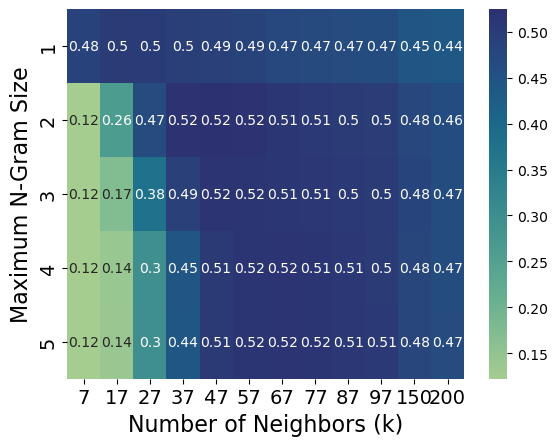

In [19]:
# Use the heatmap function from the seaborn package
plt.figure()

sns.heatmap(knn_results, annot=True, cmap="crest", xticklabels=k_sizes, yticklabels=list(range(1,max_ngram_size+1)))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Maximum N-Gram Size', fontsize=16)
plt.xlabel('Number of Neighbors (k)', fontsize=16)

plt.show()

### TEST2: Naive Bayes Classifier

In [20]:
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB

min_ngram_size = 1
max_ngram_size = 5

num_runs = max_ngram_size - min_ngram_size

# numpy array to keep track of all results
results = []

max
with tqdm(total=num_runs) as pbar:
    for i, ngram in enumerate(range(min_ngram_size, max_ngram_size+1)):
        # Create Document-Term Matrix for different n-gram sizes
        tfidf_vectorizer = tfidf_vectorizer_arr[i-1]
        X_train = tfidf_vectorizer.fit_transform(sentences_train)
        X_test = tfidf_vectorizer.transform(sentences_test)
        # Train & test model using cross validation
        model = MultinomialNB().fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores = cross_val_score(model, X_train, y_train, cv=10, scoring="f1_micro")
        mean_score = np.mean(scores)
        results.append((ngram, mean_score))
        pbar.update(1)

        #output result
        filename = "Bayes/40000_new\Bayes_"+"Ngram_"+str(ngram)+"_f1_"+"{:.3f}".format(mean_score)+".csv"
        df_output = pd.DataFrame(y_pred, columns=['Predicted'])
        df_output.to_csv(filename)

        print("======")
        print(filename)
        print(classification_report(y_test, y_pred))

 25%|██▌       | 1/4 [00:31<01:35, 31.98s/it]

Bayes/40000_new\Bayes_Ngram_1_f1_0.599.csv
              precision    recall  f1-score   support

           0       0.51      0.82      0.63       310
           1       0.75      0.64      0.69       297
           2       0.59      0.57      0.58       306
           3       0.36      0.56      0.44       293
           4       0.62      0.64      0.63       299
           5       0.84      0.36      0.51       300
           6       0.88      0.88      0.88       315
           7       0.94      0.41      0.57       242

    accuracy                           0.62      2362
   macro avg       0.69      0.61      0.62      2362
weighted avg       0.68      0.62      0.62      2362



 50%|█████     | 2/4 [00:34<00:29, 14.90s/it]

Bayes/40000_new\Bayes_Ngram_2_f1_0.566.csv
              precision    recall  f1-score   support

           0       0.53      0.81      0.64       310
           1       0.75      0.59      0.66       297
           2       0.63      0.39      0.48       306
           3       0.30      0.72      0.42       293
           4       0.63      0.61      0.62       299
           5       0.84      0.30      0.45       300
           6       0.90      0.87      0.89       315
           7       0.97      0.26      0.41       242

    accuracy                           0.58      2362
   macro avg       0.69      0.57      0.57      2362
weighted avg       0.69      0.58      0.58      2362



 75%|███████▌  | 3/4 [00:41<00:11, 11.14s/it]

Bayes/40000_new\Bayes_Ngram_3_f1_0.597.csv
              precision    recall  f1-score   support

           0       0.52      0.83      0.64       310
           1       0.77      0.64      0.70       297
           2       0.61      0.52      0.56       306
           3       0.35      0.65      0.45       293
           4       0.63      0.63      0.63       299
           5       0.86      0.35      0.50       300
           6       0.89      0.88      0.89       315
           7       0.96      0.35      0.51       242

    accuracy                           0.62      2362
   macro avg       0.70      0.61      0.61      2362
weighted avg       0.69      0.62      0.62      2362



100%|██████████| 4/4 [00:55<00:00, 12.16s/it]

Bayes/40000_new\Bayes_Ngram_4_f1_0.600.csv
              precision    recall  f1-score   support

           0       0.52      0.82      0.64       310
           1       0.76      0.66      0.70       297
           2       0.60      0.57      0.59       306
           3       0.37      0.59      0.45       293
           4       0.63      0.65      0.64       299
           5       0.84      0.37      0.51       300
           6       0.88      0.87      0.88       315
           7       0.94      0.40      0.57       242

    accuracy                           0.62      2362
   macro avg       0.69      0.62      0.62      2362
weighted avg       0.69      0.62      0.63      2362



5it [01:19, 15.86s/it]                       

Bayes/40000_new\Bayes_Ngram_5_f1_0.599.csv
              precision    recall  f1-score   support

           0       0.52      0.82      0.63       310
           1       0.75      0.65      0.69       297
           2       0.60      0.57      0.58       306
           3       0.36      0.57      0.44       293
           4       0.62      0.65      0.63       299
           5       0.84      0.36      0.51       300
           6       0.88      0.88      0.88       315
           7       0.94      0.41      0.57       242

    accuracy                           0.62      2362
   macro avg       0.69      0.61      0.62      2362
weighted avg       0.68      0.62      0.62      2362



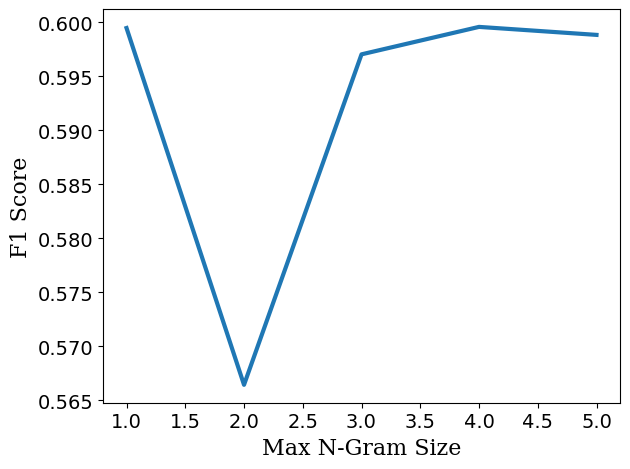

In [21]:
plt.figure()
plt.plot([s[0] for s in results], [s[1] for s in results], lw=3)
font_axes = {'family':'serif','color':'black','size':16}
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Max N-Gram Size", fontdict=font_axes)
plt.ylabel("F1 Score", fontdict=font_axes)
plt.tight_layout()
plt.show()

In [22]:
### TEST 3: Logistic Regression

In [23]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

min_ngram_size = 1
max_ngram_size = 5

num_runs = max_ngram_size - min_ngram_size

# numpy array to keep track of all results
results = []

with tqdm(total=num_runs) as pbar:
    for i, ngram in enumerate(range(min_ngram_size, max_ngram_size+1)):
        # Create Document-Term Matrix for different n-gram sizes
        tfidf_vectorizer = tfidf_vectorizer_arr[i-1]
        X_train = tfidf_vectorizer.fit_transform(sentences_train)
        X_test = tfidf_vectorizer.transform(sentences_test)
        # Train & test model using cross validation
        model = LogisticRegression(max_iter=500).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores = cross_val_score(model, X_train, y_train, cv=10, scoring="f1_micro")
        mean_score = np.mean(scores)
        results.append((ngram, mean_score))
        pbar.update(1)

        #output result
        filename = "LogisticRegression/40000_new\LR_"+"Ngram_"+str(ngram)+"_f1_"+"{:.3f}".format(mean_score)+".csv"
        df_output = pd.DataFrame(y_pred, columns=['Predicted'])
        df_output.to_csv(filename)

        print("======")
        print(filename)
        print(classification_report(y_test, y_pred))

 25%|██▌       | 1/4 [04:58<14:56, 298.80s/it]

LogisticRegression/40000_new\LR_Ngram_1_f1_0.707.csv
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       310
           1       0.80      0.73      0.76       297
           2       0.58      0.65      0.61       306
           3       0.45      0.48      0.47       293
           4       0.76      0.66      0.71       299
           5       0.72      0.60      0.65       300
           6       0.94      0.88      0.91       315
           7       0.67      0.90      0.77       242

    accuracy                           0.70      2362
   macro avg       0.71      0.71      0.70      2362
weighted avg       0.71      0.70      0.70      2362



 50%|█████     | 2/4 [07:42<07:18, 219.07s/it]

LogisticRegression/40000_new\LR_Ngram_2_f1_0.710.csv
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       310
           1       0.81      0.74      0.77       297
           2       0.59      0.62      0.61       306
           3       0.46      0.49      0.48       293
           4       0.78      0.68      0.73       299
           5       0.72      0.61      0.66       300
           6       0.94      0.88      0.91       315
           7       0.66      0.91      0.76       242

    accuracy                           0.71      2362
   macro avg       0.72      0.71      0.71      2362
weighted avg       0.72      0.71      0.71      2362



 75%|███████▌  | 3/4 [12:13<04:02, 242.82s/it]

LogisticRegression/40000_new\LR_Ngram_3_f1_0.709.csv
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       310
           1       0.82      0.73      0.77       297
           2       0.60      0.65      0.62       306
           3       0.47      0.52      0.49       293
           4       0.77      0.67      0.72       299
           5       0.72      0.59      0.65       300
           6       0.95      0.88      0.91       315
           7       0.66      0.91      0.77       242

    accuracy                           0.71      2362
   macro avg       0.72      0.71      0.71      2362
weighted avg       0.72      0.71      0.71      2362



100%|██████████| 4/4 [16:50<00:00, 256.27s/it]

LogisticRegression/40000_new\LR_Ngram_4_f1_0.708.csv
              precision    recall  f1-score   support

           0       0.75      0.74      0.75       310
           1       0.80      0.73      0.76       297
           2       0.58      0.65      0.61       306
           3       0.46      0.49      0.47       293
           4       0.77      0.67      0.71       299
           5       0.71      0.60      0.65       300
           6       0.95      0.88      0.91       315
           7       0.67      0.91      0.77       242

    accuracy                           0.70      2362
   macro avg       0.71      0.71      0.70      2362
weighted avg       0.71      0.70      0.70      2362



5it [21:20, 256.07s/it]                       

LogisticRegression/40000_new\LR_Ngram_5_f1_0.707.csv
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       310
           1       0.80      0.73      0.76       297
           2       0.58      0.65      0.61       306
           3       0.46      0.48      0.47       293
           4       0.76      0.66      0.71       299
           5       0.72      0.60      0.65       300
           6       0.95      0.88      0.91       315
           7       0.67      0.91      0.77       242

    accuracy                           0.70      2362
   macro avg       0.71      0.71      0.71      2362
weighted avg       0.71      0.70      0.71      2362



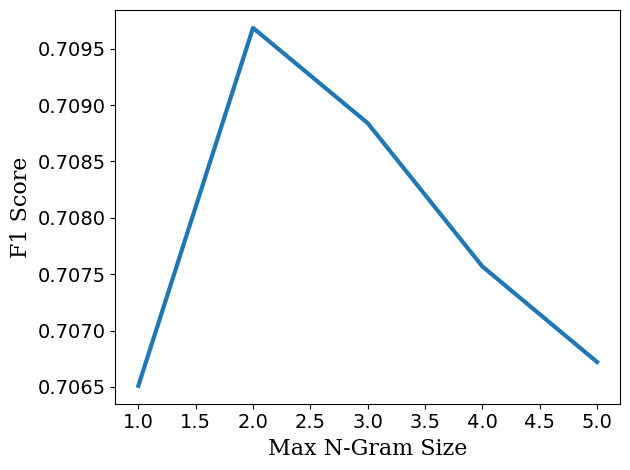

In [24]:
plt.figure()
plt.plot([s[0] for s in results], [s[1] for s in results], lw=3)
font_axes = {'family':'serif','color':'black','size':16}
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Max N-Gram Size", fontdict=font_axes)
plt.ylabel("F1 Score", fontdict=font_axes)
plt.tight_layout()
plt.show()